In [208]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import random
%matplotlib inline

np.random.seed(0) 

# step 1: generate data for binary classification

In [209]:
def generate_data(domain):
    """generate data for binary classification, where the decision boundary is a 
    sine curve.
    """
    
    boundary = np.sin(domain)
    
    x1_points = []
    x2_points = []
    labels = []

    for x in domain:
        low = np.sin(x) - 1.0
        high = np.sin(x) + 1.0
        y = random.choice(np.linspace(low, high, 500))
        
        x1_points.append(x)
        x2_points.append(y)
        labels.append(y > np.sin(x))  # 1 if above boundary, else 0

    X = []
    for pair in zip(x1_points, x2_points):
        X.append(pair)
    X = np.array(X)
    
    return X, labels, boundary

In [210]:
domain = np.linspace(-2, 5, 300)

X, label, boundary = generate_data(domain)

Text(0, 0.5, 'x2')

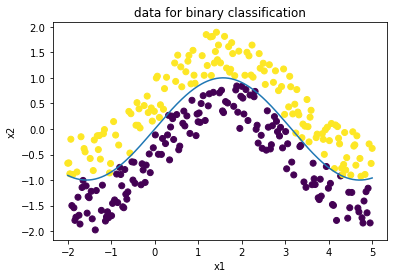

In [211]:
plt.title("data for binary classification")
plt.scatter(X[:,0], X[:, 1], c=label)
plt.plot(domain, boundary)
plt.xlabel("x1")
plt.ylabel("x2")

# 2) generate black box model
we use a random forest but could have used any model.

In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
    
def generate_f(f):
    """fit and return a black box model f.
    """    
    X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.3)
    f.fit(X_train,y_train)
    y_pred = f.predict(X_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    return f

In [213]:
f = RandomForestClassifier(n_estimators=100)
black_box_model = generate_f(f)

Accuracy: 0.9666666666666667


# 3) fetch k-nearest neighbors

In [214]:
from annoy import AnnoyIndex
n_features = 2
n_buckets = 20

ann = AnnoyIndex(n_features, metric='euclidean')
for (i, row) in enumerate(X):
    ann.add_item(i, row)
ann.build(n_buckets)

True

In [215]:
# fetch k-nearest neighbors
n_neighbors = 20
test_idx = 175  # index of the data point that we want to interpret
indices = ann.get_nns_by_item(test_idx, n_neighbors)[1:]
neighbors = [X[idx] for idx in indices]

# 4) ping black box function `f` for predictions

In [216]:
# generate data to train explainable wweighted model g
predictions = []

for neighbor in neighbors:
    pred = black_box_model.predict([neighbor])
    predictions.append(pred)

In [217]:
# compute distances to weight instances
dist = []

for neighbor in neighbors:
    d = np.linalg.norm(X[test_idx] - neighbor)  # the paper uses an exponential kernel
    dist.append(1/d)

# 5) fit a shallow linear model `g`

In [218]:
from sklearn.linear_model import SGDClassifier

G = SGDClassifier(loss='log')
G.fit(neighbors, np.array(predictions).ravel(), sample_weight=dist)  # https://stackoverflow.com/questions/7513067/weighted-logistic-regression-in-python

SGDClassifier(loss='log')

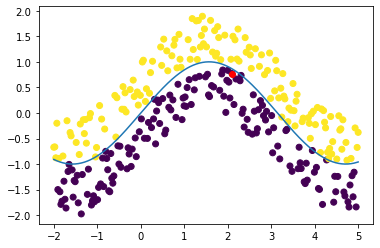

In [219]:
plt.scatter(X[:,0], X[:, 1], c=label)  # original dataset
plt.plot(X[test_idx][0], X[test_idx][1],'ro')  # test point
plt.plot(domain, boundary)  # original decision boundary 

In [220]:
G.coef_

array([[-42.50171863, 192.03825505]])

In [221]:
xx, yy = np.mgrid[-2:5:.01, -2:2:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = G.predict_proba(grid)[:, 1].reshape(xx.shape)

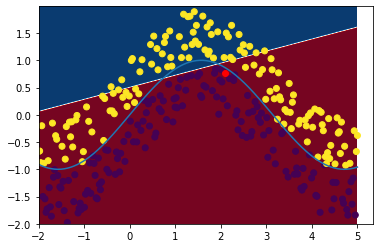

In [222]:
# plot decision boundary
f, ax = plt.subplots()
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)  # https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression

plt.scatter(X[:,0], X[:, 1], c=label)  # original dataset
plt.plot(X[test_idx][0], X[test_idx][1],'ro')  # test point
plt.plot(domain, boundary)  # original decision boundary 